# **Inicialização**

In [ ]:
#@title Conecção com o Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Importação das Bibliotecas
import time
import pandas as pd
import numpy as np
import threading
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import sort


# **Aquisição dos dados e processamento**

**Nesta seção de Aquisição de dados**

crie um novo ***elif*** com o caminho até a pasta "Processamento Paralelo e Distribuido/Lab 01/" do seu drive, após isso coloque no broco Acesso aos Aquivos o seu nome como parametro da função, também é possivel alterar as variaveis e o arquivo a ser analisado.

In [ ]:
#@title Diretorio de origem
def getDiretorio(autor):
  # arthur.estevao@du.ufes.br
  if(autor == "Arthur-UFEs"):
    pasta = "/content/drive/MyDrive/Colab Notebooks/Processamento Paralelo e Distribuido/Lab 01/"
  # arthur.estevao@du.ufes.br
  elif(autor == "Arthur"):
    pasta = "/content/drive/MyDrive/Colab Notebooks/Materias/Processamento Paralelo e Distribuido/Lab 01/"
  elif(autor == "Milena"):
    pasta = "/content/drive/MyDrive/Processamento Paralelo e Distribuido/Lab 01/"
  elif(autor == "Mayke"):
    pasta = "/content/drive/MyDrive/Processamento Paralelo e Distribuido/Lab 01/"
  return pasta

In [ ]:
#@title Acesso aos Arquivos

pasta = getDiretorio("Arthur-UFEs")

def arquivo(arq):
  dados = pd.read_csv(pasta+arq, delimiter="\n", header=None).squeeze().to_list()
  return dados

In [ ]:
#@title Variaveis
k= 5                                                      # Quantidades de segmentação
#func = sort()                                            # Função de ordenação
temp_not_seg = []                                         # Tempo não segmentado
dados = arquivo("25.csv")                                 # Base de dados
aleatorio = arquivo("aleatorio/100000.csv")               # Base de dados
invertido = arquivo("invertido/100000.csv")               # Base de dados
quaseOrdenado = arquivo("quase-ordenado/100000.csv")      # Base de dados
ordenado = arquivo("ordenado/100000.csv")                 # Base de dados

# **Merge Sort**

In [ ]:
#@title Função de Ordenação
def mergeSort(dados):
    if len(dados) > 1:
        meio = len(dados) // 2
        esqueda = dados[:meio]
        direita = dados[meio:]

        # Chamada recursiva de ordenação
        mergeSort(esqueda)
        mergeSort(direita)

        i = 0
        j = 0
        k = 0
        
        while i < len(esqueda) and j < len(direita):
          if esqueda[i] <= direita[j]:
            # Atribui o valor da metade esqueda
            dados[k] = esqueda[i]
            # Move o interador da esquerda
            i += 1
          else:
            # Atribui o valor da metade direita
            dados[k] = direita[j]
            # Move o interador da direita
            j += 1
          # vai para a próxima possição do vetor
          k += 1

        # Atribui todos os valores restantes da esquerda
        while i < len(esqueda):
          dados[k] = esqueda[i]
          i += 1
          k += 1
        # Atribui todos os valores restantes da direita
        while j < len(direita):
          dados[k]=direita[j]
          j += 1
          k += 1


# **Tempo de Execução**

In [ ]:
#@title Calculo do tempo de execução
def timeExec(dados, func=sort, thread=True):
  # Tempo inicial
  tempo_inicial = time.time()

  #Executa a função com Thread
  multThread = []
  if thread:
    while(True):
      # Pega o tempo de ordenação de cada split
      for split in dados:
        thread = threading.Thread(target=func, args=(split, ))
        multThread.append(thread)
        thread.start()
      #print(dados)

      # Verifica se todas as threads acabaram 
      for thread in multThread:
        thread.join()

      if(len(dados) == 1): break

      # Uni os splits adjacentes
      n = len(dados)//2 + 1
      multThread.clear
      for i in range(0, n, 2):
        thread = threading.Thread(target=merge, args=(dados, i, (i+1), ))
        multThread.append(thread)
        thread.start()
      #print(dados)
      for thread in multThread:
        thread.join()

      dados = list(filter(None, dados))
      #print(dados)
  #Executa a função sem Thread
  else:
    func(dados)

  # Tempo final 
  tempo_final = time.time()
  return (tempo_final - tempo_inicial)

# **Execução não segmentado**

In [ ]:
# @title Execução
# Faz a copia dos dados
ns_invert   = invertido.copy()
ns_aleat    = aleatorio.copy()
ns_ordem    = ordenado.copy()
ns_qOrderm  = quaseOrdenado.copy()

temp_not_seg = []
# Pega o tempo de Ordenação
temp_not_seg.append(timeExec(ns_invert, mergeSort, False))
temp_not_seg.append(timeExec(ns_aleat, mergeSort, False))
temp_not_seg.append(timeExec(ns_ordem, mergeSort, False))
temp_not_seg.append(timeExec(ns_qOrderm, mergeSort, False))

# **Execução Segmentada**

In [ ]:
#@title Divisão dos splits
def splitDF(dados, k, n=len(dados)):

  #função auxiliar
  splits = lambda dados, k: [dados[i:i+k] for i in range(0, n, k)]

  return list(filter(None, splits(dados, k)))

In [ ]:
# @title Merge dos splits
def merge(lista, i, j):
  lista[i] = (lista[i]+lista[j])
  lista[j] = (None)

In [ ]:
#@title Ordenação dos splits
def mergeSortParalelo(dados, func, k, n=10, fixos = True):
  array = list(np.random.randint(0, n, (1,n)))
  temp = []
  splits = []

  if(fixos):
    # Repartição dos dados
    if(k > 1):
      splits = splitDF(dados, k)
    else:
      splits.append(dados)
  else:
    # Repartição dos dados
    if(k > 1):
      splits = splitDF(array, k)
    else:
      splits.append(array)

  temp.append(timeExec(splits, func, True))
  return temp

In [ ]:
#@title Execução

tempos = []
aux = []

#mergeSortParalelo(dados, mergeSort, i)

for i in range(2, 17):
  aux.append(mergeSortParalelo(invertido, mergeSort, i))
tempos.append(aux)
aux = []
for i in range(2, 17):
  aux.append(mergeSortParalelo(aleatorio, mergeSort, i))
tempos.append(aux)
aux = []
for i in range(2, 17):
  aux.append(mergeSortParalelo(ordenado, mergeSort, i))
tempos.append(aux)
aux = []
for i in range(2, 17):
  aux.append(mergeSortParalelo(quaseOrdenado, mergeSort, i))
tempos.append(aux)

# **Comparação dos tempos de execução**

**Nesta seção *Comparação dos tempos de execução***


E feita a comparação dos tempos de execução do metodo segmentado e do não seguemetado.

  Na subseção analise gráficas é possivel obcervarmos os tempos gastos para cada valor de K, logo obcervamos que comforme almentamos o valor de K o tempo diminui até que chega em um ponto que não diminui ou começa a crescer

In [ ]:
#@title Pega o id do valor passado como parametro
def getIndexes(dfObj, value):
    listOfPos = []
     
    result = dfObj.isin([value])
     
    seriesObj = result.any()
 
    columnNames = list(seriesObj[seriesObj == True].index)
    
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
 
        for row in rows:
            #listOfPos.append((row, col))
            listOfPos.append(row)
             
    #return listOfPos
    return listOfPos[0]

Menor tempo adquirido para dados invertidos foi 0.000640 referente a k = 14


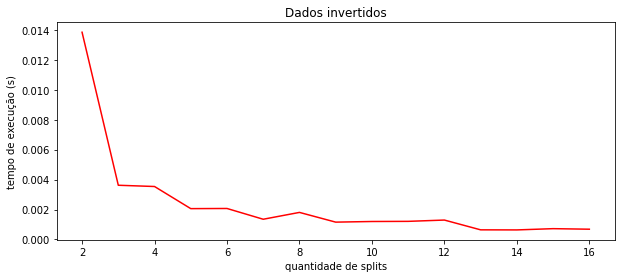

Menor tempo adquirido para dados aleatorios foi 0.000721 referente a k = 13


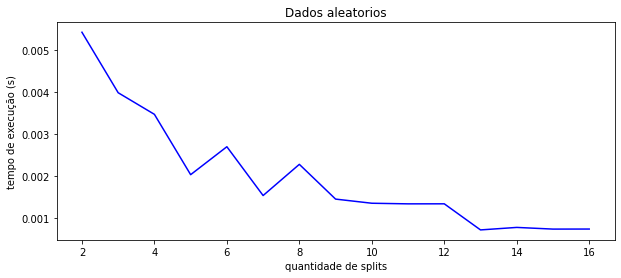

Menor tempo adquirido para dados ordenados foi 0.000686 referente a k = 15


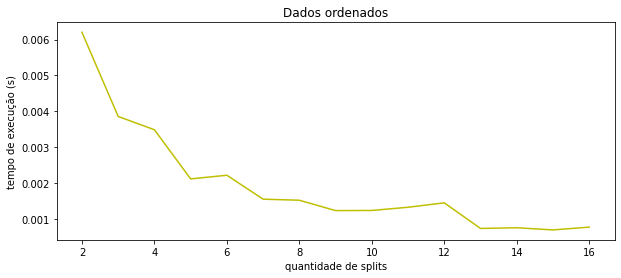

Menor tempo adquirido para dados quase ordenados foi 0.000623 referente a k = 13


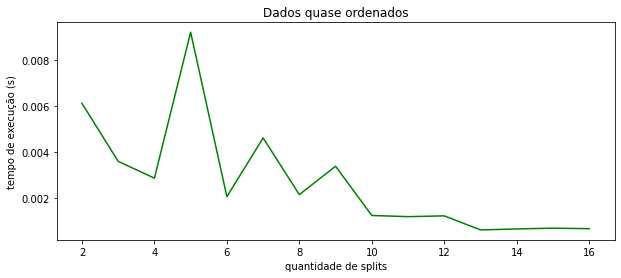

In [ ]:
#@title Analise gráfica
temp_seg = []
k = []
color = ["r","b","y","g"]
for i in range(4):
  if(i == 0):
    nome = "invertidos"
    tempAux = pd.DataFrame(tempos[0])
  elif(i == 1):
    nome = "aleatorios"
    tempAux = pd.DataFrame(tempos[1])
  elif(i == 2):
    nome = "ordenados"
    tempAux = pd.DataFrame(tempos[2])
  elif(i == 3):
    nome = "quase ordenados"
    tempAux = pd.DataFrame(tempos[3])

  tempAux.index = np.arange(2,17)
  temp_seg.append(tempAux.min()[0])
  k.append(getIndexes(tempAux, (temp_seg[i])))
  print("Menor tempo adquirido para dados {} foi {:.6f} referente a k = {}".format(nome, temp_seg[i], k[i]))
  plt.figure(figsize=(10,4))
  plt.plot(tempAux, color[i])
  plt.xlabel("quantidade de splits")
  plt.ylabel("tempo de execução (s)")
  plt.title("Dados "+ nome)
  plt.show()

Logo abaixo temos uma tabela com os melhores valores de K que podemos utilizar para encontrar o menor valor possivel de tempo, para diferentes configurações da entrada

In [ ]:
#@title Tempo de Processamento Sem Segmentação

df_temp_seg = pd.DataFrame(temp_not_seg)
df_temp_seg.index = ["Invertdido","Aleatorio","Ordenado","Quase ordenado"]
df_temp_seg.columns = ["Menores tempos em cada ordenação segmentada"]
display(df_temp_seg)

,Menores tempos em cada ordenação segmentada
Invertdido,0.654990
Aleatorio,0.857931
Ordenado,0.636325
Quase ordenado,0.615531


In [ ]:
#@title Tempo de Processamento com Segmentação
df_temp_seg = pd.DataFrame(temp_seg)
df_temp_seg.index = ["Invertdido","Aleatorio","Ordenado","Quase ordenado"]
df_temp_seg.columns = ["Menores tempos em cada ordenação segmentada"]
df_temp_seg.loc[:,"k"] = k
display(df_temp_seg)

,Menores tempos em cada ordenação segmentada,k
Invertdido,0.000640,14
Aleatorio,0.000721,13
Ordenado,0.000686,15
Quase ordenado,0.000623,13


# **Exemplos de Thread**

**Exemplo 01**

```
from threading import Thread
import time


def carrinho(velocidade,nome):
    distancia = 0
    while distancia <= 1000:
        print("Carrinho :",nome,distancia)
        distancia += velocidade
        time.sleep(0.3)



carrinho1 = Thread(target=carrinho,args=[1.1,"Ed"])
carrinho2 = Thread(target=carrinho,args=[1.2,"Paulo"])


carrinho1.start()
carrinho2.start()
```

Site: https://pt.stackoverflow.com/questions/143552/entendendo-o-conceito-de-threads-na-prática-em-python

# Execução Finalizada


In [ ]:
#@title Execução em Tempo real
k = 2
n = 400

saida = mergeSortParalelo(dados, mergeSort, k, n, False)

print("A saida para k={} em um vetor de {} numeros aleatórios é {} ".format(k, n, saida[0]))

A saida para k=2 em um vetor de 400 numeros aleatórios é 0.017975807189941406 
